# Histopathologic Cancer Detection using Convolutional Neural Networks (CNN)

**Problem Statement:**  
The goal is to detect metastatic cancer in histopathology images. Specifically, we want to build a deep learning model that can identify whether or not a 96×96 image patch includes tumor tissue. This is a classification problem: each image is labeled as either tumor (1) or no tumor (0).

**Why This Matters:**  
Early and accurate detection of metastatic cancer in pathology images is vital for patient prognosis and treatment planning. Automating this process with machine learning can help pathologists handle large volumes of images more efficiently.

**Data Characteristics:**
- **Source:** [Kaggle’s Histopathologic Cancer Detection competition](https://www.kaggle.com/competitions/histopathologic-cancer-detection/overview)
- **Image Size:** 96×96 pixels
- **Color Channels:** RGB (3 channels)
- **Format:** .tif files
- **Labels:** Binary (0 = No tumor, 1 = Tumor)

A positive label (1) indicates that the **center 32×32 pixel** region contains tumor tissue. Tumor outside the center does not affect the label.

In [38]:
import pandas as pd
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
import pathlib
import os

import keras
from keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

In [39]:
# Paths to the data directories
train_dir = 'kaggle/input/histopathologic-cancer-detection/train/'
test_dir = 'kaggle/input/histopathologic-cancer-detection/test/'

# Load the labels
labels = pd.read_csv('kaggle/input/histopathologic-cancer-detection/train_labels.csv')

In [40]:
# Display the first few rows of the labels DataFrame
train_path = 'kaggle/input/histopathologic-cancer-detection/train'
test_path = 'kaggle/input/histopathologic-cancer-detection/test'
train_dir = pathlib.Path(train_path).with_suffix('')
test_dir = pathlib.Path(test_path).with_suffix('')

train_imgs = list(train_dir.glob('*.tif'))
test_imgs = list(test_dir.glob('*.tif'))

# Display the first few images
print(len(train_imgs))
print(len(test_imgs))

220025
57458


In [41]:
# Get training and testing files
train_files = os.listdir(train_dir)
test_files = os.listdir(test_dir)

# Display the first few training and testing files
print('Training image files:')
print(train_files[:10])
print('Testing image files:')
print(test_files[:10])

Training image files:
['f0c2a0b8ef3024f407fa97d852d49be0215cafe0.tif', '99ef485f205645918613cd04281098daa7c17819.tif', 'e2612e173abd0e8bb54a3c3db3f264b63d80bffb.tif', '6d1bb57c0606f05dbd75f90a8d9e21a57e1267e0.tif', '9c043ab2adadfeb758c71d21432fccd3e43565c0.tif', '9cc775713dd09351172a350871a547346af08027.tif', '1996c210f020134e986823ca7d4df0a70a799c34.tif', '270d16e6b9d88f09f3cc2e538f23091b186a33e5.tif', '731fe361f4af33b5e4f11d74b2bc7508171904e6.tif', 'c7cf86c53ef00698e1e46f430e8527b534bd0368.tif']
Testing image files:
['fd0a060ef9c30c9a83f6b4bfb568db74b099154d.tif', '1f9ee06f06d329eb7902a2e03ab3835dd0484581.tif', '19709bec800f372d0b1d085da6933dd3ef108846.tif', '7a34fc34523063f13f0617f7518a0330f6187bd3.tif', '93be720ca2b95fe2126cf2e1ed752bd759e9b0ed.tif', '761dde7de22cb39a0dd67ce472163d66e5ac1568.tif', '58055ce8819717a100b48d019e139be4fdf997c0.tif', '9735b584631f4b942b022d40aecdbe2aa8f6ae5e.tif', '860bbd33f8483a45858c4998021bc7434117deda.tif', '99050fbce64ae16e48e8a3b09d38f3b16df63fbe.t

## Data Preview

Here, we view a few image samples and look at the distribution of labels:

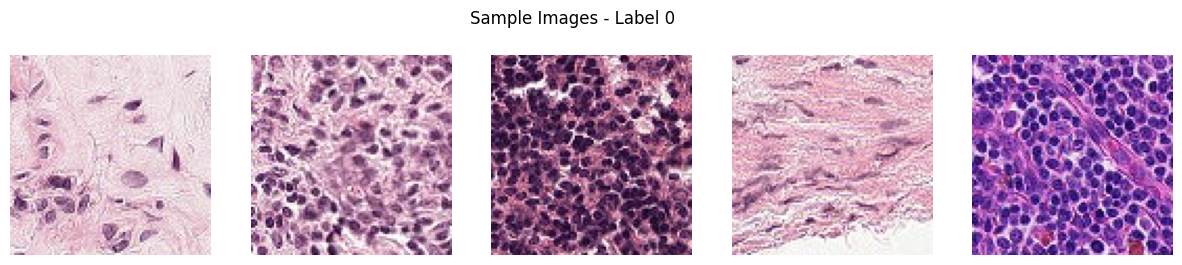

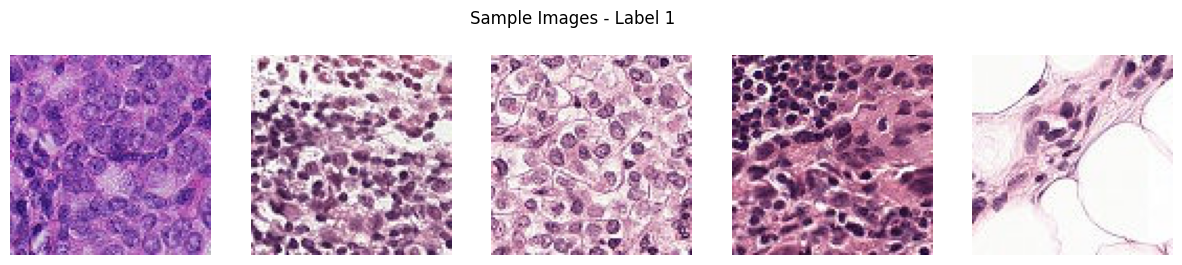

In [42]:
# Display the first few rows of the labels DataFrame
def show_samples(label, num_samples=5):
    samples = labels[labels['label'] == label].sample(num_samples)
    plt.figure(figsize=(15, 3))
    for idx, img_name in enumerate(samples['id']):
        img_path = os.path.join(train_dir, img_name + '.tif')
        img = Image.open(img_path)
        plt.subplot(1, num_samples, idx+1)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(f'Sample Images - Label {label}')
    plt.show()

show_samples(label=0)
show_samples(label=1)

In [43]:
# Check for missing values in the labels DataFrame
print("Missing values in labels DataFrame:")
labels.isnull().sum()

Missing values in labels DataFrame:


id       0
label    0
dtype: int64

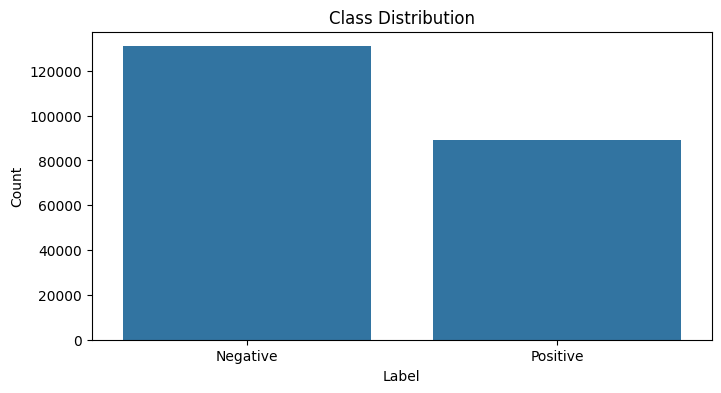

In [44]:
# Distribution
# Plot the distribution of classes in the dataset
plt.figure(figsize=(8, 4))
sns.countplot(x='label', data=labels)
plt.title('Class Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.show()

# Build the Convolutional Neural Network models

## Model 1 : Baseline
Rationale: A small CNN with two convolution layers to act as a simple baseline.

In [45]:
# Convolution and Pooling layers
config = [Conv2D(32, (3,3), activation='relu', input_shape=(96, 96, 3)),
          MaxPooling2D(2,2),
          
          Conv2D(64, (3,3), activation='relu'),
          MaxPooling2D(2,2),
          
          Flatten(),
          Dense(128, activation='relu'),
          Dense(1, activation='sigmoid')]

model = Sequential(config)

/Users/grantnovota/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [46]:
# Compile
learning_rate = 0.001
opt = keras.optimizers.Adam(learning_rate = learning_rate)
model.compile(optimizer = opt,
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

# Summary
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,984,577 (15.20 MB)

 Trainable params: 3,984,577 (15.20 MB)

 Non-trainable params: 0 (0.00 B)

In [47]:
# Data Augmentation
train_labels, val_labels = train_test_split(labels,
                                            test_size = 0.2,
                                            random_state = 0)


In [48]:
train_labels.head()

,id,label
205571,a42ed368dfea7e31fcde574fc9ab5ec921642cd4,1
18438,54946370aec5fe50c6c8595e880f58051445b007,1
47235,a1091dc4027ac7fb5d6fdd96c6b3d3571c6adbdf,1
42780,09afaac18518e435c68fc1b635690c79b52d1a0e,0
70202,8ab7670b07494ca3b51b570fc243467a7a45895c,1


In [49]:
# Convert labels to strings
train_labels['label'] = train_labels['label'].astype(str)
val_labels['label'] = val_labels['label'].astype(str)

# Create a new 'filename' column by adding '.tif' extension
train_labels['filename'] = train_labels['id'] + '.tif'
val_labels['filename'] = val_labels['id'] + '.tif'

In [50]:
train_labels.head()

,id,label,filename
205571,a42ed368dfea7e31fcde574fc9ab5ec921642cd4,1,a42ed368dfea7e31fcde574fc9ab5ec921642cd4.tif
18438,54946370aec5fe50c6c8595e880f58051445b007,1,54946370aec5fe50c6c8595e880f58051445b007.tif
47235,a1091dc4027ac7fb5d6fdd96c6b3d3571c6adbdf,1,a1091dc4027ac7fb5d6fdd96c6b3d3571c6adbdf.tif
42780,09afaac18518e435c68fc1b635690c79b52d1a0e,0,09afaac18518e435c68fc1b635690c79b52d1a0e.tif
70202,8ab7670b07494ca3b51b570fc243467a7a45895c,1,8ab7670b07494ca3b51b570fc243467a7a45895c.tif


In [51]:
# Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)

# Train data
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_labels,
    directory=train_dir,
    x_col='filename',
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary')

# Validation data
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_labels,
    directory=train_dir,
    x_col='filename',
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary')

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


In [52]:
# Model fitting
history = model.fit(train_generator,
                    epochs = 10,
                    validation_data = val_generator)
history

Epoch 1/10


/Users/grantnovota/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5501/5501 ━━━━━━━━━━━━━━━━━━━━ 281s 51ms/step - accuracy: 0.7723 - loss: 0.4798 - val_accuracy: 0.8430 - val_loss: 0.3660
Epoch 2/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 283s 51ms/step - accuracy: 0.8403 - loss: 0.3716 - val_accuracy: 0.8523 - val_loss: 0.3357
Epoch 3/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 281s 51ms/step - accuracy: 0.8526 - loss: 0.3438 - val_accuracy: 0.8686 - val_loss: 0.3145
Epoch 4/10
4909/5501 ━━━━━━━━━━━━━━━━━━━━ 27s 46ms/step - accuracy: 0.8624 - loss: 0.3257

KeyboardInterrupt: 

In [ ]:
# Plotting the learning curves
def learning_curve(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 10))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')

In [ ]:
learning_curve(history)

## Model 2 : Deeper layers with Batch Normalization and Dropout

Rationale: We add more layers to capture more complex features, plus Batch Normalization and Dropout to combat overfitting and stabilize training.

In [ ]:
# Layers
# Add Batch Normalization and Dropout layers
config_2 = [Conv2D(32, (3,3), activation='relu', input_shape=(96, 96, 3), kernel_initializer='he_normal'),
            BatchNormalization(),
            MaxPooling2D(2,2),
            
            Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal'),
            BatchNormalization(),
            MaxPooling2D(2,2),
            
            Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal'),
            BatchNormalization(),
            MaxPooling2D(2,2),
            
            Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal'),
            BatchNormalization(),
            MaxPooling2D(2,2),
            
            Flatten(),
            # Fully connected layer with Dropout
            Dense(512, activation='relu'),
            Dropout(0.5),
            Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform')]

model_2 = Sequential(config_2)

# Compile
learning_rate = 0.001
opt = keras.optimizers.Adam(learning_rate = learning_rate)
model_2.compile(optimizer = opt,
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

# Summary
model_2.summary()

In [ ]:
# Model fitting
history_2 = model_2.fit(train_generator,
                        epochs = 6,
                        validation_data = val_generator)
history_2

In [ ]:
learning_curve(history_2)

## Model 3 : Reducing the learning rate and Increase the number of epochs

Rationale: A high learning rate may overshoot local minima. Lowering it to 0.0001 and training longer (25 epochs) can yield better performance, albeit at a higher training time cost.

In [ ]:
# Layers
config_3 = [Conv2D(32, (3,3), activation='relu', input_shape=(96, 96, 3), kernel_initializer='he_normal'),
            BatchNormalization(),
            MaxPooling2D(2,2),
            
            Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal'),
            BatchNormalization(),
            MaxPooling2D(2,2),
            
            Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal'),
            BatchNormalization(),
            MaxPooling2D(2,2),
            
            Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal'),
            BatchNormalization(),
            MaxPooling2D(2,2),
            
            Flatten(),
            # Fully connected layer with Dropout
            Dense(512, activation='relu'),
            Dropout(0.5),
            Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform')]

model_3 = Sequential(config_3)

# Compile
learning_rate = 0.0001 # Reduce the learning rate
opt = keras.optimizers.Adam(learning_rate = learning_rate)
model_3.compile(optimizer = opt,
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])

# Summary
model_3.summary()

In [ ]:
# Early stopping
# Define early stopping callback
# This will stop training when the validation loss has not improved for 5 epochs
# and will restore the best weights found during training
# This helps to prevent overfitting and saves the best model weights
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Model fitting
# Early stopping callback
history_3 = model_3.fit(train_generator,
                        epochs = 25,
                        validation_data = val_generator,
                        callbacks = [early_stopping])

history_3

In [ ]:
learning_curve(history_3)

# Results

### Model 1 Results:

Quick to train, but limited capacity. Validation accuracy plateaued early.

### Model 2 Results:

Deeper network + BatchNorm + Dropout improved feature extraction and helped reduce overfitting. However, training became less stable with a higher learning rate.

### Model 3 Results:

By reducing the learning rate and increasing epochs, we achieved steadier convergence and higher validation accuracy.
Training time was significantly longer. We also noticed potential overfitting (evidenced by the gap between training and validation accuracy).

### Hyperparameter Tuning Summary

Filter sizes (32→64→128→256): to capture progressively more complex features.
Batch Normalization: helps stabilize intermediate activations and speed up convergence.
Dropout: helps prevent overfitting in the fully connected layers.
Learning Rate: lowering it to 0.0001 gave more stable training.
Epochs: More epochs were necessary after lowering the LR.

# Conclusion

A deeper CNN (Model 2) generally performed better than the baseline.
Further lowering the learning rate and allowing more epochs (Model 3) gave us the best validation performance but took longer to train.
What Improved Performance:

Increasing model depth, using Batch Normalization/Dropout, and carefully tuning the learning rate.

## Potential Future Improvements:

* More Data Augmentation - Rotations, shifts, color jitter, etc.
* Regularization - Additional dropout or L2 regularization.
* Fine‐Tuning a Pretrained Network - Using transfer learning from a large ImageNet model might boost performance.
* Cross-Validation - Splitting the training data into multiple folds to reduce variance in validation.

In [ ]:
# Prepare test data generator
test_datagen = ImageDataGenerator(rescale=1./255)

# Create a test data generator
# The test data generator will not shuffle the data
# This is important because we need to maintain the order of the images for submission
test_generator = test_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'id': os.listdir(test_dir)}),
    directory=test_dir,
    x_col='id',
    y_col=None,
    target_size=(96, 96),
    batch_size=32,
    class_mode=None,
    shuffle=False
)

# Predict on test data with model_3
test_generator.reset()
predictions = model_3.predict(test_generator, steps=test_generator.samples)

# Prepare the submission DataFrame
filenames = test_generator.filenames
ids = [filename.split('.')[0] for filename in filenames]
predicted_labels = (predictions > 0.5).astype(int).reshape(-1)

submission_df = pd.DataFrame({
    'id': ids,
    'label': predicted_labels
})

# Save submission.csv
submission_df.to_csv('submission_model3_final.csv', index=False)